In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
X_np = X.to_numpy()
y_np = y.to_numpy(int)
# y = y.astype(np.uint8)

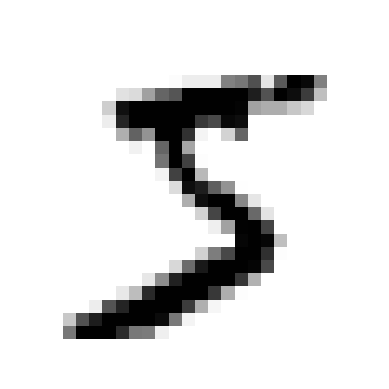

5

In [4]:
import matplotlib.pyplot as plt

some_digit = X_np[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
y_np[0]

In [5]:
# MNIST изначально разделен на train и test
X_train, X_test, y_train, y_test = X_np[:60000], X_np[60000:], y_np[:60000], y_np[60000:]

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [12]:
from sklearn.base import BaseEstimator
import numpy as np

# При ассимитричной выборке
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [13]:
round(sum(False == (y_np == 5)) / len(y_np), 4)

0.9098

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

res = confusion_matrix(y_train_5, y_train_pred)
res

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343847


In [16]:
# decision_function возврат суммы очков для каждого образа
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [17]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

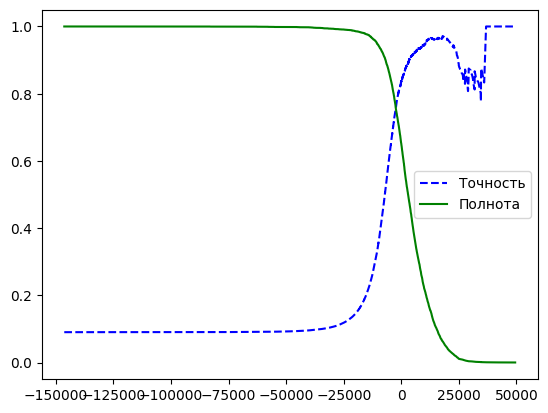

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_thresholds(precision, recalls, thresholds):
  plt.plot(thresholds, precision[:-1], "b--", label="Точность")
  plt.plot(thresholds, recalls[:-1], "g-", label="Полнота")
  plt.legend()
  plt.show()

plot_precision_recall_vs_thresholds(precision, recalls, thresholds)

In [20]:
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


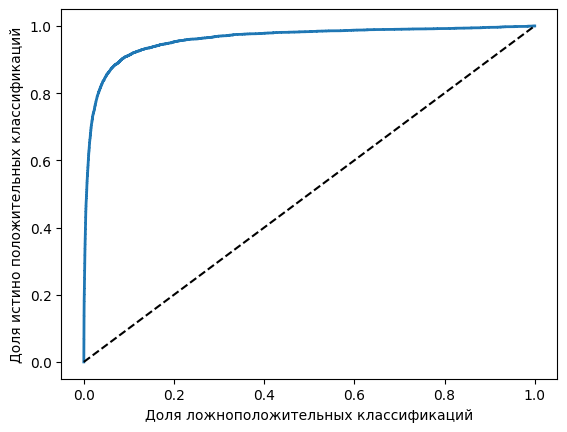

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlabel("Доля ложноположительных классификаций")
  plt.ylabel("Доля истино положительных классификаций")
  plt.show()

plot_roc_curve(fpr, tpr)

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

1 идеально, 0.5 рандомный

Кривая PR, используется когда положительный класс является редким или ложноположительные классификации заботят больше, чем ложноотрицательные

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

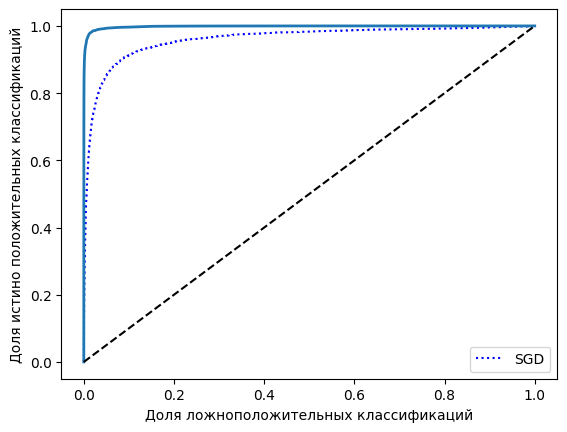

In [24]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")
plot_roc_curve(fpr_forest, tpr_forest, 'Случайный лес')

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983100809899164

In [26]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(X_train, y_train)
pred = svc_clf.predict([some_digit])
pred

array([5])

N * (N-1) / 2, Количество OvO (one versus one), 45 двоичных классификаторов и выбрала класс у которого больше победных дуэлей

In [27]:
some_digit_score = svc_clf.decision_function([some_digit])
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [30]:
print(np.argmax(some_digit_score))
print(svc_clf.classes_)
print(svc_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [31]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
pred = ovr_clf.predict([some_digit])
print(pred)
len(ovr_clf.estimators_)

[5]


45

OneVsOneClassifier - двоичный классификатор, делает много дуэлей(классификаторов)

OneVsRestClassifier - Один против всех, N классификаторов, получаем из каждого классификатора сумму баллов для каждого изображения, у кого больше баллов, тот и побеждает

OneVsOneClassifier, сравнивает допустим 0,1 затем 0,2 затем 0,3 ... После этого он считает количество выигранных дуэлей, у кого больше тот и предсказывается.

OneVsRestClassifier, берет 10 классификаторов и считает сумму принадлежности к классу, если сумма выше остальных, тогда предсказываем её.

In [32]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3])

In [33]:
sgd_clf.decision_function([some_digit])
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_np)
cross_val_score(sgd_clf, X_train_scaled, y_np, cv=3, scoring="accuracy")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9011314 , 0.89962714, 0.90237003])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


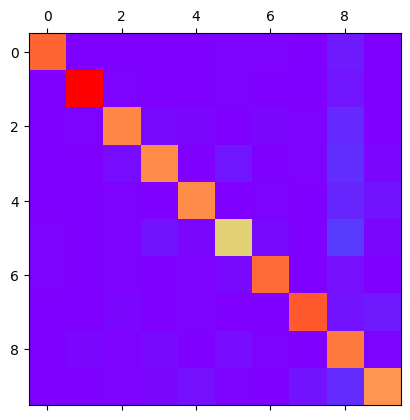

In [37]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_np, cv=3)
conf_mx = confusion_matrix(y_np, y_train_pred)
plt.matshow(conf_mx, cmap="rainbow")
plt.show()

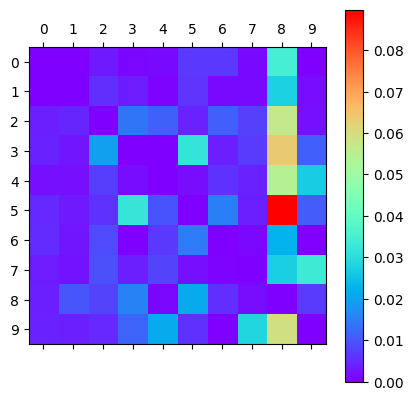

In [39]:
# матрица неточностей
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Рассматриваем, над какиими классами нам необходимо поработать(улучшить)
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="rainbow")
plt.xticks(range(norm_conf_mx.shape[1]))
plt.yticks(range(norm_conf_mx.shape[0]))
plt.colorbar()
plt.show()

**Многозадачная классификация**

Распознавание лиц (Алиса, Боб, Чарли)

На фото есть Алиса и Чарли -> система должна вывести [True, False, True]

In [44]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_np >= 7)
y_train_odd = (y_np % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_np, y_np)

knn_clf.predict([some_digit])

array([5])

In [46]:
y_train_knn_pred = cross_val_predict(knn_clf, X_np, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9762678267868119

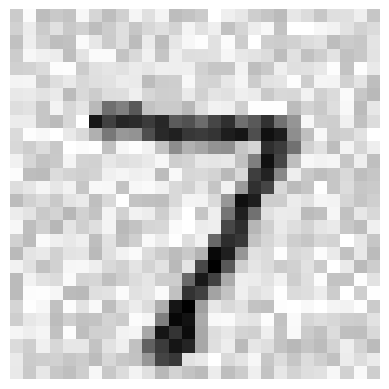

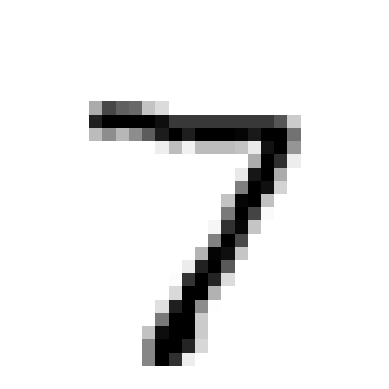

In [48]:
X_train, X_test, y_train, y_test = X_np[:60000], X_np[60000:], y_np[:60000], y_np[60000:]

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_digit_noise = X_test_mod[0].reshape((28,28))
some_digit = y_test_mod[0].reshape((28,28))

plt.imshow(some_digit_noise, cmap="binary")
plt.axis("off")
plt.show()
plt.imshow(some_digit, cmap="binary")
plt.axis("off")
plt.show()

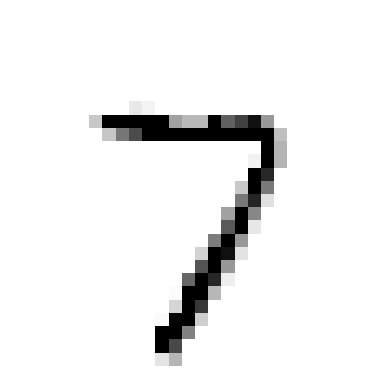

In [58]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
res = clean_digit.reshape((28,28))

plt.imshow(res, cmap="binary")
plt.axis("off")
plt.show()

Упражнение 1:

Достичь 97% точности

In [67]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=4, test_size=0.5, random_state=42)
X_scale = scaler.fit_transform(X_np)
sss.get_n_splits(X_scale, y_np)

4

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

for train_index, test_index in sss.split(X_np, y_np):
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("-------KNN-------")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

    mlp_clf.fit(X_train, y_train)
    y_pred = mlp_clf.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("-------MLP-------")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

-------KNN-------
F1 Score: 0.9664751268002926
Accuracy: 0.9665428571428571


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-------MLP-------
F1 Score: 0.9270313343444778
Accuracy: 0.9269714285714286
-------KNN-------
F1 Score: 0.9658412146790084
Accuracy: 0.9659142857142857
-------MLP-------
F1 Score: 0.9581110004615024
Accuracy: 0.9581428571428572
-------KNN-------
F1 Score: 0.9660327649833181
Accuracy: 0.9661142857142857
-------MLP-------
F1 Score: 0.9585177789950585
Accuracy: 0.9584571428571429
-------KNN-------
F1 Score: 0.9651618026449682
Accuracy: 0.9652285714285714
-------MLP-------
F1 Score: 0.9586884091524311
Accuracy: 0.9586857142857143


In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()),
])

param_grid = {
    'pca__n_components': [5, 10, 20],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=sss, scoring='accuracy')

grid_search.fit(X_np, y_np)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

for train_index, test_index in sss.split(X_np, y_np):
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    y_pred = grid_search.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("-------------------------")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

Best parameters found:  {'knn__n_neighbors': 5, 'knn__weights': 'distance', 'pca__n_components': 20}
Best accuracy found:  0.9435285714285715
-------------------------
F1 Score: 1.0
Accuracy: 1.0
-------------------------
F1 Score: 1.0
Accuracy: 1.0
-------------------------
F1 Score: 1.0
Accuracy: 1.0
-------------------------
F1 Score: 1.0
Accuracy: 1.0


Сделать аугментацию данных и посмотреть результат

<ipython-input-73-80d0093ab075>:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


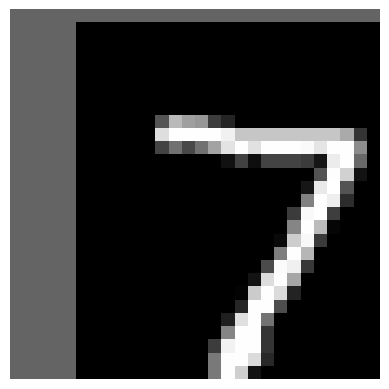

In [73]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plt.imshow(shift_digit(some_digit, 5, 1, new=100).reshape((28,28)), cmap="gray")
plt.axis("off")
plt.show()

In [74]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((175000, 784), (175000,))

In [75]:
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)

knn_clf.fit(X_train_expanded, y_train_expanded)

pred = knn_clf.predict(X_test)

accuracy_score(y_test, pred)

0.9763714285714286

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])
y_train = train_data["Survived"]

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()